In [1]:
import cv2
import pytesseract
import os
import csv
import re

In [2]:
# set dataname
dataname = '0506_3'

In [3]:
# get video
video_path = f'{dataname}.mp4' # video: dataname.mp4
cap = cv2.VideoCapture(video_path) # capture

In [4]:
# check whether the video is open
if not cap.isOpened():
    print("Error opening video file")
    exit()

In [5]:
# get frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS) # fps got
print(f"Frame rate: {fps} fps")  # check frame rate

Frame rate: 58.90048826035598 fps


In [6]:
# open a dirs to save frames
output_folder = f'frames_{dataname}' # default output folder name: frames_dataname
os.makedirs(output_folder, exist_ok=True)

# save the frames of the video
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break  # already get the video
    
    frame_filename = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
    crop_frame = frame[108:888, 360:1370]  # [y1:y2, x1:x2] crop
    cv2.imwrite(frame_filename, crop_frame)
    
    frame_idx += 1

cap.release()
print(f"Saved {frame_idx} frames.")

Saved 1092 frames.


In [7]:
# Set the tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r"D:\tesseract\tesseract.exe"

# Set folders
input_folder = f'frames_{dataname}'          # Input image folder
output_csv = f'{dataname}.csv'          # Output CSV file

# Prepare to store timestamps
timestamps = []
last_timestamp = None 

# Get all image files
file_list = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Timestamp regex
timestamp_pattern = re.compile(r'\d{2}[:;]\d{2}[:;]\d{2}[\.,]\d{3}')

def timestamp_to_seconds(timestamp_str):
    h, m, s_ms = timestamp_str.split(":")
    s, ms = s_ms.split(".")
    return round(int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000, 3)

for filename in file_list:
    img_path = os.path.join(input_folder, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Cannot read {filename}")
        continue

    # Define timestamp region
    y1, y2, x1, x2 = 0, 90, 40, 340
    timestamp_area = img[y1:y2, x1:x2]
    gray = cv2.cvtColor(timestamp_area, cv2.COLOR_BGR2GRAY)

    # OCR
    custom_config = r'--oem 3 --psm 7'
    timestamp_text = pytesseract.image_to_string(gray, config=custom_config).strip()
    print(f"{filename} -> {timestamp_text}")

    if not timestamp_pattern.fullmatch(timestamp_text):
        print(f"❌ Timestamp format error at {filename}: {timestamp_text}")
        print("⛔ Stopping the process due to invalid timestamp format.")
        break

    # Clean OCR output
    corrected_timestamp = timestamp_text.replace(';', ':').replace(',', '.')
    total_seconds = timestamp_to_seconds(corrected_timestamp)

    if total_seconds == last_timestamp:
        print(f"🗑️ Duplicate timestamp {corrected_timestamp} at {filename}, deleting...")
        os.remove(img_path)
        continue

    # update last timestamp
    last_timestamp = total_seconds
    timestamps.append([filename, total_seconds])

    # erase timestamp
    img[y1:y2, x1:x2] = 0
    cv2.imwrite(img_path, img)

# Export CSV
with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Timestamp (seconds)"])
    writer.writerows(timestamps)

print("✅ Done: Duplicates removed, timestamps saved, and images updated.")

frame_0000.png -> 15:37:04.772
frame_0001.png -> 15:37:04.772
🗑️ Duplicate timestamp 15:37:04.772 at frame_0001.png, deleting...
frame_0002.png -> 15:37:04.772
🗑️ Duplicate timestamp 15:37:04.772 at frame_0002.png, deleting...
frame_0003.png -> 15:37:04.772
🗑️ Duplicate timestamp 15:37:04.772 at frame_0003.png, deleting...
frame_0004.png -> 15:37:04.848
frame_0005.png -> 15:37:04.848
🗑️ Duplicate timestamp 15:37:04.848 at frame_0005.png, deleting...
frame_0006.png -> 15:37:04.848
🗑️ Duplicate timestamp 15:37:04.848 at frame_0006.png, deleting...
frame_0007.png -> 15:37:04.848
🗑️ Duplicate timestamp 15:37:04.848 at frame_0007.png, deleting...
frame_0008.png -> 15:37:04.848
🗑️ Duplicate timestamp 15:37:04.848 at frame_0008.png, deleting...
frame_0009.png -> 15:37:04.848
🗑️ Duplicate timestamp 15:37:04.848 at frame_0009.png, deleting...
frame_0010.png -> 15:37:04.919
frame_0011.png -> 15:37:04.919
🗑️ Duplicate timestamp 15:37:04.919 at frame_0011.png, deleting...
frame_0012.png -> 15:37:0

In [8]:
import pandas as pd
import numpy as np

data_frame = pd.read_csv(f'{dataname}.csv')
data_sensor = pd.read_csv(f'linear_position_{dataname}.csv')

print(data_frame.columns)
print(data_sensor.columns)

Index(['Filename', 'Timestamp (seconds)'], dtype='object')
Index(['Timestamp (s)', 'X (mm)', 'Y (mm)', 'Z (mm)', 'Roll (deg)',
       'Pitch (deg)', 'Yaw (deg)'],
      dtype='object')


In [9]:
data_frame = data_frame.rename(columns={'Timestamp (seconds)': 'Timestamp (s)'})

interp_columns = ['X (mm)', 'Y (mm)', 'Z (mm)', 'Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']

# linear interpolation
for col in interp_columns:
    data_frame[col] = np.interp(
        data_frame['Timestamp (s)'],           # timestamps corresponding to files
        data_sensor['Timestamp (s)'],     # timestamps of sensor
        data_sensor[col]              # data of sensor
    )

# output csv
data_frame.to_csv(f'{dataname}_final_data.csv', index = False)

print(f"✅ {dataname}_final_data.csv is saved successfully!")

✅ 0506_3_final_data.csv is saved successfully!


In [10]:
data_frame

,Filename,Timestamp (s),X (mm),Y (mm),Z (mm),Roll (deg),Pitch (deg),Yaw (deg)
0,frame_0000.png,56224.772,-92.286242,286.085509,-90.455228,120.773480,22.520837,74.632132
1,frame_0004.png,56224.848,-98.134817,300.731830,-101.600605,121.159077,22.398785,75.108525
2,frame_0010.png,56224.919,-104.231373,312.517988,-110.298539,121.211171,23.282850,74.950163
3,frame_0017.png,56225.005,-112.963053,324.574851,-119.991464,122.685686,23.019109,75.489998
4,frame_0023.png,56225.075,-120.340004,332.779622,-126.005975,123.349561,22.968247,75.951899
...,...,...,...,...,...,...,...,...
240,frame_1068.png,56242.934,-4.521439,0.871874,-31.274802,87.584396,56.343830,-55.167812
241,frame_1071.png,56243.000,-4.994797,0.528333,-30.825675,87.754170,56.184466,-55.454710
242,frame_1076.png,56243.075,-5.624038,0.349622,-30.533246,87.475990,56.061484,-55.863893
243,frame_1079.png,56243.150,-5.737289,-0.327895,-30.256627,87.642332,56.295458,-55.837319


In [11]:
# set dataname
dataname = '0506_3'

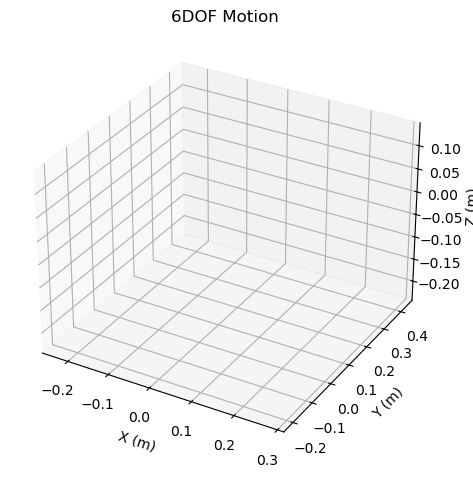

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R

# 讀取資料
df = pd.read_csv(f"{dataname}_final_data.csv")
pos = df[["X (mm)", "Y (mm)", "Z (mm)"]].to_numpy() / 1000
rpy = df[["Roll (deg)", "Pitch (deg)", "Yaw (deg)"]].to_numpy()
rotations = R.from_euler('xyz', np.deg2rad(rpy))

# 初始化繪圖
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(np.min(pos[:, 0]) - 0.1, np.max(pos[:, 0]) + 0.1)
ax.set_ylim(np.min(pos[:, 1]) - 0.1, np.max(pos[:, 1]) + 0.1)
ax.set_zlim(np.min(pos[:, 2]) - 0.1, np.max(pos[:, 2]) + 0.1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('6DOF Motion')

trajectory, = ax.plot([], [], [], 'k-', lw=1)
quivers = []

def update(frame):
    global quivers
    # 刪除上一幀的箭頭
    for q in quivers:
        q.remove()
    quivers = []

    trajectory.set_data(pos[:frame+1, 0], pos[:frame+1, 1])
    trajectory.set_3d_properties(pos[:frame+1, 2])

    p = pos[frame]
    R_mat = rotations[frame].as_matrix()

    for i, color in enumerate(['r', 'g', 'b']):
        v = R_mat[:, i]
        q = ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2],
                      color=color, length=0.05, normalize=True)
        quivers.append(q)
    return [trajectory] + quivers

# 建立動畫
anim = FuncAnimation(fig, update, frames=len(pos), interval=50, blit=False)

# 顯示動畫
plt.tight_layout()
plt.show()

# 儲存為 GIF（MP4 請確認你安裝 ffmpeg）
anim.save(f"{dataname}_6dof_motion.gif", writer='pillow', fps=20)


